In [549]:
## A toy model for exploring enhanced sampling methods.

In [501]:
import numpy as np
import numpy.random
import scipy
import matplotlib.pyplot as plt

In [ ]:
### monte Carlo on a potential.

In [82]:
#define the potential - these can be altered.
mean1 = 1.0
mean2 = 9.0
cut1 = 4.0
cut2 = 6.0
const1 = 0.0
const2 = 2.0
barrier = 60.0 # at (cut1+cut2)/2
k1 = 5
k2 = 5

def lower_pot(x):
    pot = k1*(x-mean1)**2 + const1
    return pot

def upper_pot(x):
    pot = k2*(x-mean2)**2 + const2
    return pot

def interpolate_pot(x):
    x1 = cut1
    x2 = cut2
    x3 = (cut1+cut2)/2
    y1 = lower_pot(cut1)
    y2 = upper_pot(cut2)
    y3 = barrier
    # lagrange interpolation formula for the potential barrier is
    return y1*(x-x2)*(x-x3)/((x1-x2)*(x1-x3)) + y2*(x-x1)*(x-x3)/((x2-x1)*(x2-x3)) + y3*(x-x1)*(x-x2)/((x3-x1)*(x3-x2))

def potential(x):
    # define it as a piecewise potential to make it possible to vectorize.
    return np.piecewise(x,[x<cut1,x>cut2],[lower_pot,upper_pot,interpolate_pot])

Now let's plot this potential!

(-2.0, 12.0)

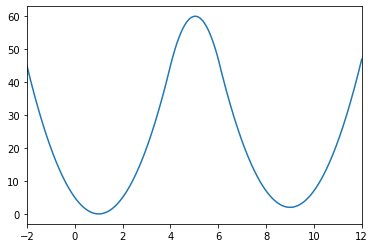

In [515]:
x = np.linspace(-2,12,1000)
plt.plot(x,potential(x))
plt.xlim([-2,12])

We've talked about how important the probability distribution is to look at. What does the probability distribution look like at different temperatures?

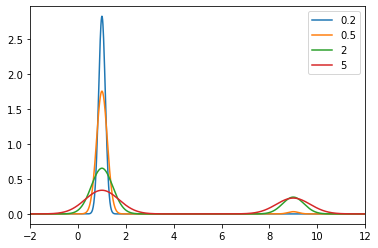

In [518]:

Temps = [0.2,0.5,2,5]

for T in Temps:
    # determine the normalizing constant - very important!
    Q = scipy.integrate.quad(lambda x: np.exp(-potential(x)/T),-10,20)[0]
    #now plot the probability distribibution
    plt.plot(x,np.exp(-potential(x)/T)/Q,label=T) # we set k_B =1; we don't care about specific units.
plt.xlim([-2,12])
plt.legend()
plt.show()


Now let's define Markov Chain Monte Carlo on this system

In [519]:
def MCstep_1D(xold,T,potential):

    newstep = np.random.normal()  # symmetric (in this case, Gaussian) proposal to move up and down.
    xnew = xold+newstep
    oldp = potential(xold)
    newp = potential(xnew)
    
    if newp < oldp:  # if the energy is lower, move!
        return xnew
    else:  # if the energy is higher, we have to compute a probability of moving.
        if np.random.random() < np.exp(-(newp-oldp)/T):
            return xnew
        else:
            return xold


Now let's simulate this system!

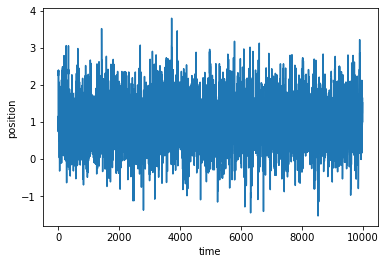

In [520]:
ntraj = 10000  # number of steps to take
T = 5 # set the temperature

xtraj = np.zeros(ntraj)
xtraj[0]=1.0  # set the initial position
for i in range(ntraj-1):
    xtraj[i+1] = MCstep_1D(xtraj[i],T,potential)
    
# now plot the trajectory over time.    
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

Let's look at histogram of where the system is.

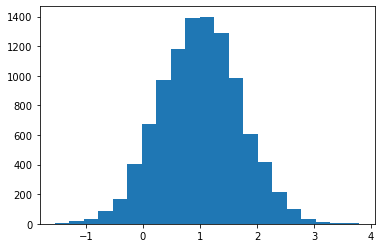

In [523]:
plt.hist(xtraj,bins=int(ntraj**(1/3)))
plt.show()

(Have the user try different temperatures)

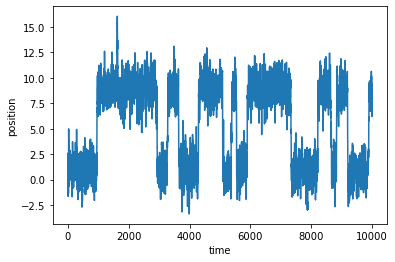

In [525]:
ntraj = 10000
T = 20
xtraj = np.zeros(ntraj)
xtraj[0]=1.0
for i in range(ntraj-1):
    xtraj[i+1] = MCstep_1D(xtraj[i],T,potential)
    
# now plot the trajectory over time.    
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

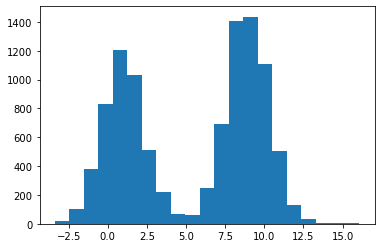

In [526]:
plt.hist(xtraj,bins=int(ntraj**(1/3)))
plt.show()

### Escaping from minima

Idea 1: Why not just heat the system up?

Discuss problems; at high enough temperatures to cross all the barriers, we might not 
What's worse, we might even make the temperature so high that we miss the mountain passes that we WANT to go though.
Example: protein unfolding at 400 K is not the same as protein folding at 320 K.
    

Idea 2: Why don't I just add a potential that cancels the other one out?

We don't acually know it!  In high dimensional spaces then the overall space is. If we are trying to move a particle on the a ceramic surface, in the presence of a solvent, from point 1 to point 2, then what is the dimensionality of the path you move it on?  And what is the dimensionality of the overall space?

This is what metadynamics is about! Tuesday. 


In [550]:
def biased_potential(x):
    return potential(x) - potential(x)

Idea 3: define some auxiliary potentials that bridge the gap.

In [530]:
def ip(c1,c2,n,i):
    # linearly iterpolate between c1 and c2, in n steps, returning the ith step along the interpolation.
    # when i=0, it's c1
    # when i=n, it's c2
    return c1*(n-i)/n + c2*(i/n)

In [532]:
nstates = 5
potentials = []
potentials.append(potential)
for i in range(1,nstates):
    potentials.append(lambda x, i=i: ip(k1,k2,nstates,i)*((x-ip(mean1,mean2,nstates,i))**2) + ip(const1,const2,nstates,i))

Let's plot these potentials.

(0.0, 70.0)

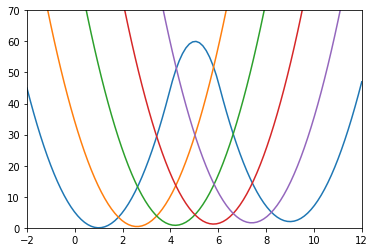

In [533]:
x = np.linspace(-2,12,100)
for p in potentials:
    plt.plot(x,p(x))
plt.xlim([-2,12])
plt.ylim([0,70])

A new idea: Let's do Monte Carlo BETWEEN states (potentials)
1. Pick a random other state (symmetric!)
2. Use the Metropolis criteria to decide to go up or down.

(We have to define a new MC coordinate step so we can keep track of the state we are in).

In [565]:
def MCstep_2D_x(xold,i,T,potential):

    newstep = np.random.normal()  # symmetric (in this case, Gaussian) proposal to move up and down.
    xnew = xold+newstep
    oldp = potential(xold)
    newp = potential(xnew)
    
    if newp < oldp:  # if the energy is lower, move
        return xnew
    else:
        if np.random.random() < np.exp(-(newp-oldp)/T):
            return xnew
        else:
            return xold


And now our MC state step:

In [535]:
def MCstep_2D_state(x,iold,T,potentials):

    newstep = np.random.randint(0,len(potentials))  # jump to any random state - this is symmetric!
    inew = newstep
    oldp = potentials[iold](x)
    newp = potentials[inew](x)
    
    if newp < oldp:  # if the energy is lower, move
        return inew
    else:
        if np.random.random() < np.exp(-(newp-oldp)/T):
            return inew
        else:
            return iold

Now here is our algorithm; 50% of the time do a state move, 50% do a coordinate move.

In [536]:
ntraj = 10000
T = 5
xtraj = np.zeros(ntraj)
itraj = np.zeros(ntraj,int)
xtraj[0]=1.0
itraj[0] = 0
for i in range(ntraj-1):
    if np.random.random() < 0.5:  # half the time, do a coordinate move
        xtraj[i+1] = MCstep_2D_x(xtraj[i],itraj[i],T,potential[i])
        itraj[i+1] = itraj[i]
    else:   # half the time do a state move
        itraj[i+1] = MCstep_2D_state(xtraj[i],itraj[i],T,potentials)
        xtraj[i+1] = xtraj[i]

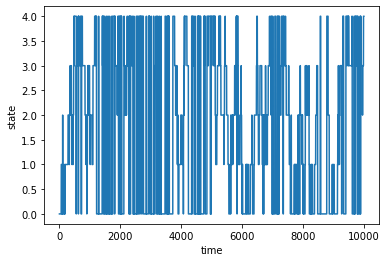

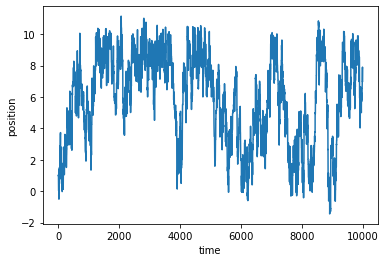

In [537]:
# let's plot the trajectory - which is now 2D!
plt.plot(itraj)
plt.ylabel('state')
plt.xlabel('time')
plt.show()
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

A problem: we don't necessarily know HOW to transform our system to carry the system from one minimum to another!


Idea 4: Let's take the existing potential, but add a spring that ``carries'' it from one minimum to another.

In [560]:
nsteps = 10
umbrella_potentials = []
umbrella_potentials.append(potential)
for i in range(1,nsteps):
    # for each potential, we add a harmonic well that gradually moves across the system
    # We'll leave off the constant, since maybe we don't KNOW the constant yet.
    umbrella_potentials.append(lambda x, i=i: potential(x) + ip(k1,k2,nsteps,i)*((x-ip(mean1,mean2,nsteps,i))**2))

(0.0, 70.0)

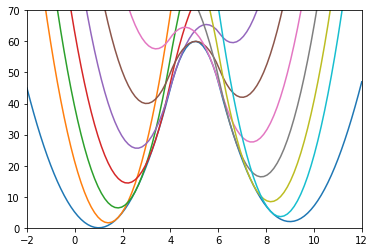

In [561]:
x = np.linspace(-2,12,100)
for p in umbrella_potentials:
    plt.plot(x,p(x))
plt.xlim([-2,12])
plt.ylim([0,70])


In [562]:
ntraj = 50000
T = 5
xtraj = np.zeros(ntraj)
itraj = np.zeros(ntraj,int)
xtraj[0]=1.0
itraj[0] = 0
for i in range(ntraj-1):
    if np.random.random() < 0.5:  # half the time, do a coordinate move
        xtraj[i+1] = MCstep_2D_x(xtraj[i],itraj[i],T,umbrella_potentials)
        itraj[i+1] = itraj[i]
    else:   # half the time do a state move
        itraj[i+1] = MCstep_2D_state(xtraj[i],itraj[i],T,umbrella_potentials)
        xtraj[i+1] = xtraj[i]

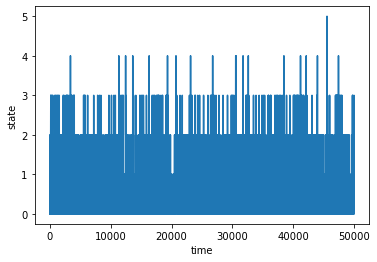

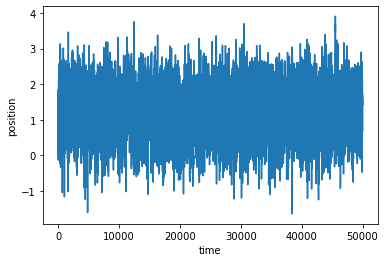

In [541]:
# let's plot the trajectory
plt.plot(itraj)
plt.ylabel('state')
plt.xlabel('time')
plt.show()
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

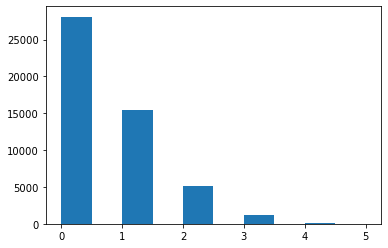

In [542]:
plt.hist(itraj)
plt.show()

OK, we need to change the potential some more - we need to make the intermediate states lower in energy.  
Note that this is the same as changing the _free energy_ of the intermediate states.  Let's guesstimate. 

In [552]:
nsteps = 10
weights = [0,-3,-8,-18,-35,-50,-35,-18,-8,-3]
wumbrella_potentials = []  # weighted umbrella potentials
wumbrella_potentials.append(potential)
for i in range(1,nsteps):
    wumbrella_potentials.append(lambda x, i=i: potential(x) + weights[i]+ ip(k1,k2,nsteps,i)*((x-ip(mean1,mean2,nsteps,i))**2) + ip(const1,const2,nsteps,i))

(-6.0, 70.0)

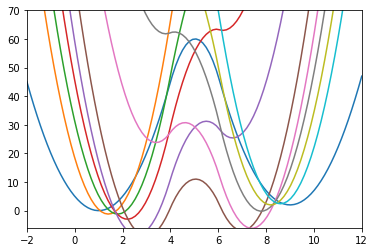

In [555]:
x = np.linspace(-2,12,100)
for p in wumbrella_potentials:
    plt.plot(x,p(x))
plt.xlim([-2,12])
plt.ylim([-6,70])


In [556]:
ntraj = 50000
T = 5
xtraj = np.zeros(ntraj)
itraj = np.zeros(ntraj,int)
xtraj[0]=1.0
itraj[0] = 0
for i in range(ntraj-1):
    if np.random.random() < 0.5:  # half the time, do a coordinate move
        xtraj[i+1] = MCstep_2D_x(xtraj[i],itraj[i],T,wumbrella_potentials)
        itraj[i+1] = itraj[i]
    else:   # half the time do a state move
        itraj[i+1] = MCstep_2D_state(xtraj[i],itraj[i],T,wumbrella_potentials)
        xtraj[i+1] = xtraj[i]

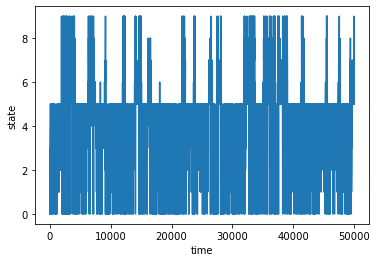

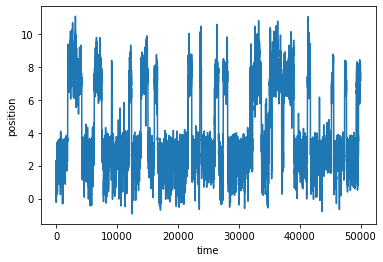

In [557]:
# let's plot the trajectory
plt.plot(itraj)
plt.ylabel('state')
plt.xlabel('time')
plt.show()
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

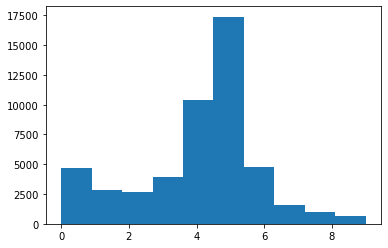

In [558]:
plt.hist(itraj)
plt.show()

How can we do better than this?  What are our choices?

In [559]:
print(T)

5


In [424]:
energies = np.zeros([nsteps,ntraj])
for j in range(nsteps):
    for i in range(ntraj):
        energies[j,:] = wumbrella_potentials[j](xtraj)/T

In [425]:
np.shape(energies)

(10, 50000)

In [426]:
import pymbar
from pymbar import MBAR

In [427]:
N_k = np.histogram(itraj)[0]
print(np.shape(N_k))
print(np.shape(energies))

(10,)
(10, 50000)


In [428]:
mbar=MBAR(energies,N_k,verbose=True)

In [429]:
results = mbar.compute_free_energy_differences()

In [430]:
results['Delta_f'][:,0]*5

array([ 0.        , -2.78805553, -2.85571848, -1.05560907,  4.60048803,
        7.35940008,  1.41753277, -4.53582792, -6.52466042, -6.7788251 ])

In [433]:
np.log(N_k/N_k[0])*5

array([ 0.        , -2.34240586, -2.7676991 , -0.89436988,  5.29932739,
        7.38714488,  1.70389929, -3.81269587, -6.3631962 , -7.14680988])

In [490]:
## umbrella sampling

#Let's carry out simulations of each umbrella.
npots = len(umbrella_potentials)
nstage = 1000
T = 5
xtraj = np.zeros(nstage*npots)
xtraj[0]=1.0
n=0
for p in wumbrella_potentials:
    for i in range(nstage):
        if n+1<nstage*npots:
            xtraj[n+1] = MCstep_1D(xtraj[n],T,p)
            n=n+1

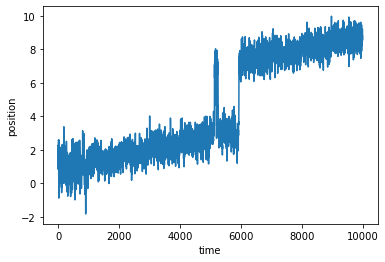

In [491]:
# let's plot the trajectory
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

In [496]:
ntraj = len(xtraj)
energies = np.zeros([len(wumbrella_potentials),len(xtraj)])
for j in range(nsteps):
    for i in range(ntraj):
        energies[j,:] = umbrella_potentials[j](xtraj)
energies = energies/T

In [497]:
N_k = nstage*np.ones(len(umbrella_potentials))
print(np.shape(N_k))
print(np.shape(energies))

(10,)
(10, 10000)


In [498]:
mbar=MBAR(energies,N_k,verbose=True)
results = mbar.compute_free_energy_differences()
results['Delta_f'][:,0]*5

array([  0.        ,  -4.1448464 ,  -9.29303256, -17.74472872,
       -29.41394657, -43.64150137, -40.47457793, -29.5118723 ,
       -21.79374139, -17.40038927])

Let's try at different temperatures.  We will need to redefine state move!

In [575]:
def MCstep_2D_stateT(x,iold,Ts,potential):

    newstep = np.random.randint(0,len(Ts))  # jump to any random state - this is symmetric!
    inew = newstep
    pot = potential(x)
    oldPT = pot/Ts[iold]
    newPT = pot/Ts[inew]
    
    if newPT < oldPT:  # if the energy is lower, move
        return inew
    else:
        if np.random.random() < np.exp(-(newPT-oldPT)):
            return inew
        else:
            return iold

In [579]:
ntraj = 10000
Ts = [1,5,10,20,40]
xtraj = np.zeros(ntraj)
itraj = np.zeros(ntraj,int)
xtraj[0]=1.0
itraj[0] = 0
for i in range(ntraj-1):
    if np.random.random() < 0.5:  # half the time, do a coordinate move
        xtraj[i+1] = MCstep_2D_x(xtraj[i],itraj[i],Ts[itraj[i]],potentials[0])
        itraj[i+1] = itraj[i]
    else:   # half the time do a state move
        itraj[i+1] = MCstep_2D_stateT(xtraj[i],itraj[i],Ts,potentials[0])
        xtraj[i+1] = xtraj[i]

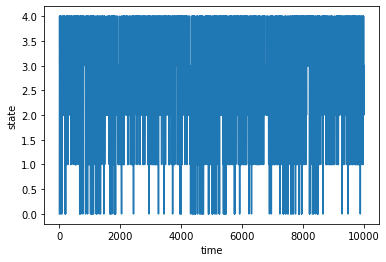

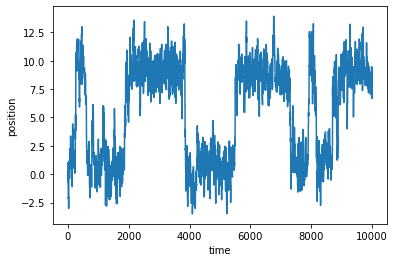

In [581]:
# let's plot the trajectory
plt.plot(itraj)
plt.ylabel('state')
plt.xlabel('time')
plt.show()
plt.plot(xtraj)
plt.ylabel('position')
plt.xlabel('time')
plt.show()

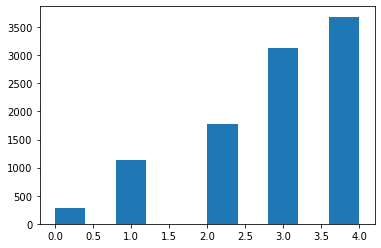

In [582]:
plt.hist(itraj)
plt.show()

In [ ]:
This works too!